# Collecting Brazil's 2022 presidential election polls data
> A tutorial on how to collect, filter and prepare for analysis Brazil's 2022 presidential election polls data.

- toc: true 
- badges: true
- comments: true
- categories: [data-science]
- hide: false
- search_exclude: false
- image: images/chart-preview.png

## Context

This year [more than 146 million fellow Brazilian](https://www.tse.jus.br/eleitor/estatisticas-de-eleitorado/consulta-quantitativo) are going to choose our new President...

## Data sources

### Pool data
- [Poder360 polls database](https://www.poder360.com.br/banco-de-dados/)
### Voters statistics

- [TSE: Voters statistics by Region](https://www.tse.jus.br/eleitor/estatisticas-de-eleitorado/consulta-quantitativo)
- [TSE: Voters statistics by sex and age](https://www.tse.jus.br/eleitor/estatisticas-de-eleitorado/estatistica-do-eleitorado-por-sexo-e-faixa-etaria)

### Dashboard
- [App](https://chance-lula-ganhar-1o-turno.github.io/)
- [Repositório: Chance de Lula ganhar no primeiro turno](https://github.com/chance-lula-ganhar-1o-turno)
  

## Analysis

### Importing libraries

In [7]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import dirichlet
from pathlib import Path
from tqdm.notebook import tqdm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Load and transform data

In [8]:
#noshow 
columns_to_use = ["pesquisa_id", "cenario_id", "turno", "partido",
                  "candidato", "cenario_descricao", "instituto",
                  "percentual", "data_pesquisa", "qtd_entrevistas",
                  "qtd_mencoes","grupo"]

HDI = [0.025, 0.5, 0.975] # quantiles

In [9]:
def enrich_and_filter(df: pd.DataFrame) ->pd.DataFrame:
    df['qtd_mencoes'] = df.percentual * df.qtd_entrevistas / 100.0
    df['grupo'] = 'OUTROS'
    df.loc[(df.partido == 'PT'), 'grupo'] = 'LULA'
    df.loc[(df.partido.isna()), 'grupo'] = 'NULO'

    return df[columns_to_use]

In [10]:
def get_most_recent_file() -> Path:
    data_dir = Path('../assets/data/elections2022/')
    return sorted(data_dir.glob('2022*.csv'))[-1]
print(get_most_recent_file())

../assets/data/elections2022/20220121.csv


In [11]:
def get_most_recent_df() -> pd.DataFrame:
    return enrich_and_filter(pd.read_csv(get_most_recent_file(),
                                         sep=',',
                                         parse_dates=True,
                                         dayfirst=True)
                             )


In [12]:
raw_df = get_most_recent_df()
raw_df.head()

,pesquisa_id,cenario_id,turno,partido,candidato,cenario_descricao,instituto,percentual,data_pesquisa,qtd_entrevistas,qtd_mencoes,grupo
0,9750,24567,1,NaN,não sabe / não respondeu,cenário 1 - estimulado - 1º turno,Vox Populi,12.0,2021-11-04,2000,240.0,NULO
1,9750,24567,1,NaN,branco / nulo / nenhum,cenário 1 - estimulado - 1º turno,Vox Populi,10.0,2021-11-04,2000,200.0,NULO
2,9750,24567,1,PSD,Rodrigo Pacheco,cenário 1 - estimulado - 1º turno,Vox Populi,0.0,2021-11-04,2000,0.0,OUTROS
3,9750,24567,1,PT,Lula,cenário 1 - estimulado - 1º turno,Vox Populi,44.0,2021-11-04,2000,880.0,LULA
4,9750,24567,1,sem partido,Bolsonaro,cenário 1 - estimulado - 1º turno,Vox Populi,21.0,2021-11-04,2000,420.0,OUTROS


In [13]:
def prepare_df(raw_df: pd.DataFrame) -> pd.DataFrame:
    table_df = raw_df.pivot_table(values=['qtd_mencoes'],
                        index=['data_pesquisa', 'instituto'],
                        columns=['grupo'],
                        aggfunc=np.sum)
    table2 = table_df.reset_index(col_level=1).copy()
    table2.columns = [a[1] for a in table2.columns.to_flat_index()]
    table2["TOTAL"] = table2['LULA'] + table2['NULO'] + table2['OUTROS']
    table2["mes"] = pd.to_datetime(table2['data_pesquisa']).dt.strftime('%Y_%m')
    return table2

In [14]:
df = prepare_df(raw_df)
df

,data_pesquisa,instituto,LULA,NULO,OUTROS,TOTAL,mes
0,2021-11-04,Vox Populi,880.000,440.000,660.000,1980.0,2021_11
1,2021-11-06,Quaest,990.240,288.820,783.940,2063.0,2021_11
2,2021-11-19,Paraná Pesquisas,704.980,270.680,1044.340,2020.0,2021_11
3,2021-11-20,Futura,740.000,142.000,1118.000,2000.0,2021_11
4,2021-11-24,PoderData,850.000,225.000,1400.000,2475.0,2021_11
5,2021-11-29,Atlas,1883.628,140.832,2376.540,4401.0,2021_11
6,2021-12-05,Quaest,937.020,244.440,855.540,2037.0,2021_12
7,2021-12-09,Ideia Big Data,444.000,156.000,600.000,1200.0,2021_12
8,2021-12-11,MDA,856.856,306.306,838.838,2002.0,2021_12
9,2021-12-13,Futura,758.000,170.000,1072.000,2000.0,2021_12


In [15]:
def simulate_prob_freq(concentration: np.array, iters=10_000, N=100_000) -> float:
    priors = stats.dirichlet.rvs(concentration, iters)
    cnt = 0
    for i in range(iters):
        votes = stats.multinomial(n=100_000, p = priors[i]).rvs()[0]
        if votes[0] > votes[2]:
            cnt += 1
    return cnt/iters * 100
simulate_prob_freq(np.array([723, 186, 780]))
#stats.multinomial(n=100_000, p = np.array([0.45, 0.11, 0.44])).rvs()

7.5

In [16]:
def run_prob_weekly(simulate_prob):
    prior = np.array([1,1,1])
    posterior = np.array([0,0,0])
    for obj in df.itertuples():
        like = np.array([obj.LULA, obj.NULO, obj.OUTROS])
        posterior = prior * 50/prior.sum() + like * 50/like.sum()
        print(obj.data_pesquisa, posterior, simulate_prob(posterior))
        prior = posterior

run_prob_weekly(simulate_prob_freq)

2021-11-04 [38.88888889 27.77777778 33.33333333] 74.58
2021-11-06 [43.44444444 20.88888889 35.66666667] 80.93
2021-11-19 [39.17222222 17.14444444 43.68333333] 31.430000000000003
2021-11-20 [38.08611111 12.12222222 49.79166667] 10.39
2021-11-24 [36.21477273 10.60656566 53.17866162] 3.42
2021-11-29 [39.50738636  6.90328283 53.58933081] 6.69
2021-12-05 [42.75369318  9.45164141 47.7946654 ] 29.21
2021-12-09 [39.87684659 11.22582071 48.8973327 ] 16.74
2021-12-11 [41.3384233  13.26291035 45.39866635] 33.39
2021-12-13 [39.61921165 10.88145518 49.49933318] 15.559999999999999
2021-12-13 [43.80960582 12.44072759 43.74966659] 50.9
2021-12-16 [45.90480291 11.22036379 42.87483329] 62.17
2021-12-16 [44.73457967 11.55077596 43.71464437] 53.6
2021-12-21 [42.36728984 11.27538798 46.35732218] 33.67
2022-01-09 [44.14282859 11.76014297 44.09702844] 49.66
2022-01-12 [43.64004175 12.2526205  44.10733775] 47.339999999999996
2022-01-13 [42.52709158 11.68186581 45.79104261] 36.26


In [17]:
mes = df.groupby("mes").sum().reset_index()
mes

,mes,LULA,NULO,OUTROS,TOTAL
0,2021_11,6048.848,1507.332,7382.820,14939.0
1,2021_12,7356.516,1973.626,7586.858,16917.0
2,2022_01,1955.000,535.000,1975.000,4465.0


In [18]:
def run_prob_monthly(simulate_prob):
    prior = np.array([1,1,1])
    posterior = np.array([0,0,0])
    df_by_mes = df.groupby("mes").sum().reset_index()
    for obj in df_by_mes.itertuples():
        # print(obj)
        like = np.array([obj.LULA, obj.NULO, obj.OUTROS])
        posterior = prior * 500/prior.sum() + like * 500/like.sum()
        print(obj.mes, posterior, simulate_prob(posterior))
        prior = posterior
run_prob_monthly(simulate_prob_freq)

2021_11 [369.11823638 217.11622822 413.7655354 ] 5.25
2021_12 [401.98880431 166.8907381  431.1204576 ] 15.28
2022_01 [419.91937416 143.35578338 436.72484246] 28.27


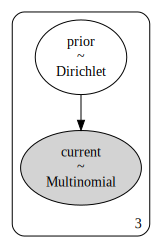

In [19]:
def build_model(prior, observed) -> pm.Model:
    observed = observed.astype("int32")
    with pm.Model() as dirichlet_model:
        # beta = pm.Beta("beta", alpha=8, beta=1)
        beta = 1.0
        previous_month_prior = pm.Dirichlet(
            "prior", a=prior, shape=(3,),
        )

        pm.Multinomial(
            "current", n=observed.sum(), p=(previous_month_prior * beta), observed=observed, shape=(3,)
        )
    
    return dirichlet_model
model = build_model(np.ones(3), np.ones(3))
pm.model_to_graphviz(model)

In [20]:

def sampling(model: pm.Model, samples=2000, chains=2):
    with model:
        dirichlet_trace = pm.sample(samples, tune=2000, chains=chains, return_inferencedata=True, progressbar=False)
        ppc = pm.fast_sample_posterior_predictive(dirichlet_trace, 5000)
    return dirichlet_trace , ppc

def calc_prob_lula_win(model, trace, niter=30, ppc=None):
    simul = []
    if ppc:
        lula = ppc['current'][:, 0]
        others = ppc['current'][:, 2]
        simul.append((lula > others).mean() * 100.0)
    for _ in tqdm(range(niter)):
        with model:
            ppc = pm.fast_sample_posterior_predictive(trace, 10000)
        lula = ppc['current'][:, 0]
        others = ppc['current'][:, 2]
        simul.append((lula > others).mean() * 100.0)
    simul = np.array(simul)
    return np.quantile(simul, q=HDI)

### Weekly update

In [21]:
flat_prior = prior = np.array([400.0, 130.0, 470.0])

df_by_mes = df.groupby("mes").sum().reset_index()
# for obj in df_by_mes.itertuples():
df = df.append(pd.DataFrame({"data_pesquisa": ["2022-01-20"],
                        "mes": ["2022_01"],
                        "LULA":[1260],
                        "NULO":[360],
                        "OUTROS":[1350],
                        "TOTAL": [3000],
                        "instituto":["PoderData"]}))
print(df)
for obj in df.itertuples():
    observed = np.array([obj.LULA, obj.NULO, obj.OUTROS])
    print(f">>> observed = {observed}")
    model = build_model(prior, observed)
    trace, ppc = sampling(model)
    posterior = ppc['current']
    # print(f">>> posterior.shape={posterior.shape}")
    prior = dirichlet.mle(posterior/posterior.sum(axis=1).reshape(-1, 1))
    # print('dirichlet.mle(posterior/posterior.sum(axis=1).reshape(-1, 1))=,', prior)
    qs = calc_prob_lula_win(model, trace, ppc=ppc)
    # print(f">>> mes={obj.mes}, updaed_prior={prior},  qs={qs}% <<<")
    print(f">>> data_pesquisa={obj.data_pesquisa}, updaed_prior={prior},  qs={qs}% <<<");
    post_prob = posterior/posterior.sum(axis=1).reshape(-1, 1)
    print(f"lula=", np.quantile(post_prob[:, 0], q=HDI))
    print(f"nulo=", np.quantile(post_prob[:, 1], q=HDI))
    print(f"demais=", np.quantile(post_prob[:, 2], q=HDI))
    

   data_pesquisa         instituto      LULA     NULO    OUTROS   TOTAL  \
0     2021-11-04        Vox Populi   880.000  440.000   660.000  1980.0   
1     2021-11-06            Quaest   990.240  288.820   783.940  2063.0   
2     2021-11-19  Paraná Pesquisas   704.980  270.680  1044.340  2020.0   
3     2021-11-20            Futura   740.000  142.000  1118.000  2000.0   
4     2021-11-24         PoderData   850.000  225.000  1400.000  2475.0   
5     2021-11-29             Atlas  1883.628  140.832  2376.540  4401.0   
6     2021-12-05            Quaest   937.020  244.440   855.540  2037.0   
7     2021-12-09    Ideia Big Data   444.000  156.000   600.000  1200.0   
8     2021-12-11               MDA   856.856  306.306   838.838  2002.0   
9     2021-12-13            Futura   758.000  170.000  1072.000  2000.0   
10    2021-12-13              Ipec   960.960  280.280   760.760  2002.0   
11    2021-12-16         Datafolha  1759.680  366.600  1539.720  3666.0   
12    2021-12-16         

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-11-04, updaed_prior=[519.42033812 231.05402053 458.181055  ],  qs=[97.1075 97.32   97.54  ]% <<<
lula= [0.4020202  0.42979798 0.45808081]
nulo= [0.16919192 0.19090909 0.21363636]
demais= [0.35251263 0.37929293 0.40606061]
>>> observed = [990.24 288.82 783.94]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The acceptance probability does not match the target. It is 0.8940038903182808, but should be close to 0.8. Try to increase the number of tuning steps.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-11-06, updaed_prior=[594.34194233 204.13748069 488.48458058],  qs=[99.8875 99.94   99.97  ]% <<<
lula= [0.43521349 0.46191169 0.48908297]
nulo= [0.13925279 0.15866084 0.1785541 ]
demais= [0.35274139 0.37942746 0.40708394]
>>> observed = [ 704.98  270.68 1044.34]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-11-19, updaed_prior=[485.8220075  177.35596125 573.6131063 ],  qs=[0.1975 0.32   0.4175]% <<<
lula= [0.36570862 0.39296333 0.42021804]
nulo= [0.12438057 0.1432111  0.16402379]
demais= [0.43607532 0.46382557 0.49108028]
>>> observed = [ 740.  142. 1118.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-11-20, updaed_prior=[456.96693492 118.4957194  631.13640877],  qs=[0. 0. 0.]% <<<
lula= [0.351 0.379 0.406]
nulo= [0.0815 0.0985 0.115 ]
demais= [0.4945    0.5235    0.5510125]
>>> observed = [ 850.  225. 1400.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
The acceptance probability does not match the target. It is 0.8848508119736274, but should be close to 0.8. Try to increase the number of tuning steps.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-11-24, updaed_prior=[525.23162065 138.2172682  817.24622736],  qs=[0. 0. 0.]% <<<
lula= [0.33050505 0.35474747 0.37979798]
nulo= [0.07919192 0.09333333 0.10828283]
demais= [0.52646465 0.55191919 0.57737374]
>>> observed = [1883.628  140.832 2376.54 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
The acceptance probability does not match the target. It is 0.8809249205257212, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-11-29, updaed_prior=[1043.39159452  120.12162115 1383.59267372],  qs=[0. 0. 0.]% <<<
lula= [0.39077063 0.40963855 0.4287338 ]
nulo= [0.0390998  0.04705615 0.05524551]
demais= [0.52421005 0.5433053  0.5621789 ]
>>> observed = [937.02 244.44 855.54]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-05, updaed_prior=[614.22237662 112.98841399 694.03865128],  qs=[1.175 1.35  1.605]% <<<
lula= [0.40667976 0.43222004 0.45726916]
nulo= [0.06532417 0.07956778 0.09430255]
demais= [0.46267191 0.48821218 0.51375246]
>>> observed = [444. 156. 600.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-09, updaed_prior=[335.19018135  85.54021699 410.11907938],  qs=[0.1725 0.25   0.3775]% <<<
lula= [0.37       0.40333333 0.43666667]
nulo= [0.08333333 0.1025     0.12416667]
demais= [0.46083333 0.49333333 0.52585417]
>>> observed = [856.856 306.306 838.838]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-11, updaed_prior=[491.94282054 161.74259806 515.06125671],  qs=[21.435  22.47   22.9175]% <<<
lula= [0.3925 0.421  0.4495]
nulo= [0.119 0.138 0.159]
demais= [0.413  0.4405 0.468 ]
>>> observed = [ 758.  170. 1072.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-13, updaed_prior=[476.70683517 126.30098827 604.85619572],  qs=[0.   0.   0.02]% <<<
lula= [0.3675 0.3945 0.423 ]
nulo= [0.0875 0.1045 0.1215]
demais= [0.473  0.501  0.5295]
>>> observed = [960.96 280.28 760.76]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-13, updaed_prior=[554.41524501 157.08000072 526.69168352],  qs=[79.1325 79.71   80.2525]% <<<
lula= [0.42      0.448     0.4750125]
nulo= [0.109  0.1265 0.1465]
demais= [0.398  0.4255 0.453 ]
>>> observed = [1759.68  366.6  1539.72]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
The acceptance probability does not match the target. It is 0.8838069563299985, but should be close to 0.8. Try to increase the number of tuning steps.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-16, updaed_prior=[980.68143215 221.91939413 875.94490664],  qs=[99.1275 99.29   99.4325]% <<<
lula= [0.45087336 0.47161572 0.49344978]
nulo= [0.09334061 0.10671397 0.12063319]
demais= [0.40010917 0.42139738 0.44186681]
>>> observed = [440. 120. 450.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-16, updaed_prior=[342.21600935  82.59620453 319.82963692],  qs=[80.6525 81.46   82.17  ]% <<<
lula= [0.42376238 0.45940594 0.4950495 ]
nulo= [0.08910891 0.11089109 0.13465347]
demais= [0.39405941 0.42970297 0.46435644]
>>> observed = [1200.  330. 1470.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-21, updaed_prior=[677.22752916 180.7376383  784.27127813],  qs=[0.1625 0.25   0.3125]% <<<
lula= [0.388      0.41233333 0.436     ]
nulo= [0.09533333 0.10966667 0.12533333]
demais= [0.45333333 0.47766667 0.50166667]
>>> observed = [900. 240. 820.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2022-01-09, updaed_prior=[553.72740883 147.90020092 563.67255394],  qs=[37.8    38.6    39.3475]% <<<
lula= [0.40969388 0.4377551  0.46479592]
nulo= [0.0994898  0.11683673 0.13469388]
demais= [0.41887755 0.44540816 0.47346939]
>>> observed = [440. 130. 450.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2022-01-12, updaed_prior=[298.56151423  83.64214597 305.47818391],  qs=[37.9225 38.77   39.6025]% <<<
lula= [0.39705882 0.43431373 0.47156863]
nulo= [0.09901961 0.12156863 0.14607843]
demais= [0.40686275 0.44411765 0.48137255]
>>> observed = [615. 165. 705.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2022-01-13, updaed_prior=[367.52428258 100.30483541 407.28515392],  qs=[7.095  7.64   8.0075]% <<<
lula= [0.38653199 0.42020202 0.45252525]
nulo= [0.09360269 0.11447811 0.13602694]
demais= [0.43232323 0.46531987 0.4983165 ]
>>> observed = [1260.  360. 1350.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2022-01-20, updaed_prior=[708.46831729 200.55839803 765.32681335],  qs=[6.4575 6.88   7.25  ]% <<<
lula= [0.3996633  0.42323232 0.44747475]
nulo= [0.1043771  0.11952862 0.13569024]
demais= [0.43333333 0.45690236 0.48181818]


In [22]:
# az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model), figsize=(10,5));
l = [1,2,3]
print(*l)

1 2 3


In [23]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prior[0],0.423,0.008,0.409,0.439,0.0,0.0,1945.0,2134.0,1.0
prior[1],0.120,0.005,0.110,0.130,0.0,0.0,1485.0,2336.0,1.0
prior[2],0.457,0.008,0.442,0.472,0.0,0.0,2758.0,3125.0,1.0


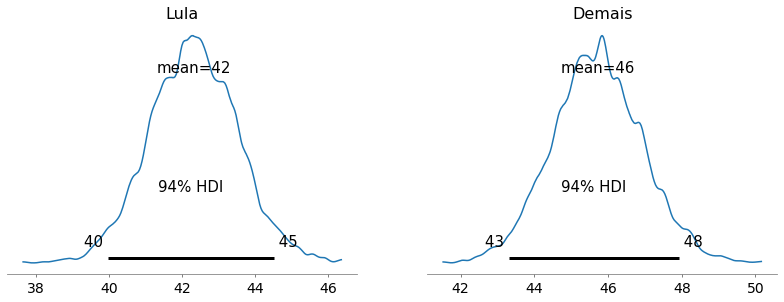

In [24]:
# fig, ax = plt.subplots(2, figsize=(10,6))
lula = ppc['current'][:,0] / ppc['current'].sum(axis=1) * 100
demais = ppc['current'][:,2] / ppc['current'].sum(axis=1) * 100
az.plot_posterior({'Lula': lula, 'Demais': demais});
#az.plot_posterior({}, ax=ax[1])

In [25]:
a0 = np.array([100, 299, 100])
D0 = np.random.dirichlet(a0, 1000)
D0

array([[0.17820303, 0.57677432, 0.24502264],
       [0.19010246, 0.5866622 , 0.22323534],
       [0.17823914, 0.57297348, 0.24878738],
       ...,
       [0.21723924, 0.61218479, 0.17057597],
       [0.19052775, 0.62235303, 0.18711923],
       [0.21965462, 0.5852267 , 0.19511868]])

## MONTHLY

In [26]:
flat_prior = prior = np.array([420.0, 130.0, 450.0])

df_by_mes = df.groupby("mes").sum().reset_index()
for obj in df_by_mes.itertuples():
    observed = np.array([obj.LULA, obj.NULO, obj.OUTROS])
    print(f">>> observed = {observed}")
    model = build_model(prior, observed)
    trace, ppc = sampling(model)
    posterior = ppc['current']
    # print(f">>> posterior.shape={posterior.shape}")
    prior = dirichlet.mle(posterior/posterior.sum(axis=1).reshape(-1, 1))
    # print('dirichlet.mle(posterior/posterior.sum(axis=1).reshape(-1, 1))=,', prior)
    qs = calc_prob_lula_win(model, trace, 100, ppc=ppc)
    print(f">>> mes={obj.mes}, updaed_prior={prior},  qs={[str(q)+'%' for q in qs]} <<<")
    # print(f">>> data_pesquisa={obj.data_pesquisa}, updaed_prior={prior},  qs={qs}% <<<");
    post_prob = posterior/posterior.sum(axis=1).reshape(-1, 1)
    print(f"lula=", np.quantile(post_prob[:, 0], q=HDI))
    print(f"nulo=", np.quantile(post_prob[:, 1], q=HDI))
    print(f"demais=", np.quantile(post_prob[:, 2], q=HDI))



>>> observed = [6048.848 1507.332 7382.82 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


  0%|          | 0/100 [00:00<?, ?it/s]

>>> mes=2021_11, updaed_prior=[3135.36825329  794.13571124 3796.78465527],  qs=['0.0%', '0.0%', '0.0%'] <<<
lula= [0.39479146 0.40583785 0.41688425]
nulo= [0.09593627 0.10276495 0.10959363]
demais= [0.48041775 0.49133025 0.50257917]
>>> observed = [7356.516 1973.626 7586.858]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


  0%|          | 0/100 [00:00<?, ?it/s]

>>> mes=2021_12, updaed_prior=[4263.47087861 1124.14318101 4625.87984094],  qs=['0.0%', '0.01%', '0.02%'] <<<
lula= [0.41619864 0.42571682 0.43582767]
nulo= [0.10605971 0.11226722 0.11841709]
demais= [0.45214159 0.46204552 0.4714159 ]
>>> observed = [3215.  895. 3325.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


  0%|          | 0/100 [00:00<?, ?it/s]

>>> mes=2022_01, updaed_prior=[2268.5933464   612.58331321 2411.9674393 ],  qs=['1.5699999999999998%', '1.87%', '2.07%'] <<<
lula= [0.41560188 0.42851379 0.44196369]
nulo= [0.1071957  0.11566913 0.12441157]
demais= [0.44263618 0.45568258 0.46872898]


In [27]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prior[0],0.429,0.004,0.422,0.436,0.0,0.0,1664.0,2434.0,1.0
prior[1],0.116,0.002,0.111,0.120,0.0,0.0,1319.0,1645.0,1.0
prior[2],0.456,0.004,0.448,0.462,0.0,0.0,2840.0,2847.0,1.0


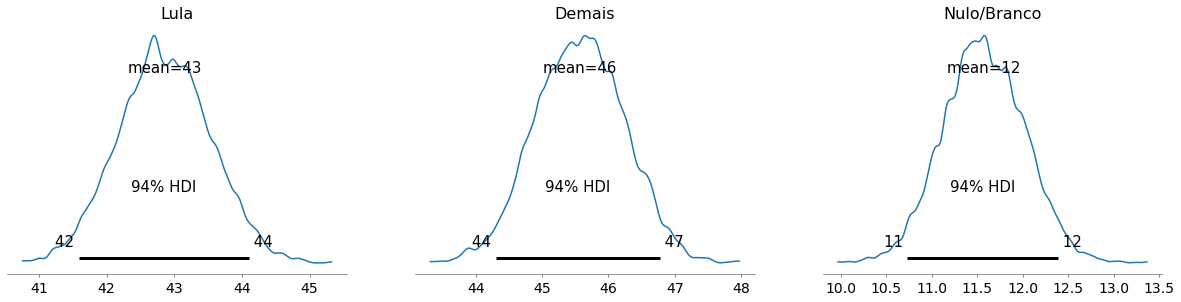

In [28]:
lula = ppc['current'][:,0] / ppc['current'].sum(axis=1) * 100.00
nulo = ppc['current'][:,1] / ppc['current'].sum(axis=1) * 100.00
demais = ppc['current'][:,2] / ppc['current'].sum(axis=1) * 100.00
az.plot_posterior({'Lula': lula, 'Demais': demais, 'Nulo/Branco':nulo});

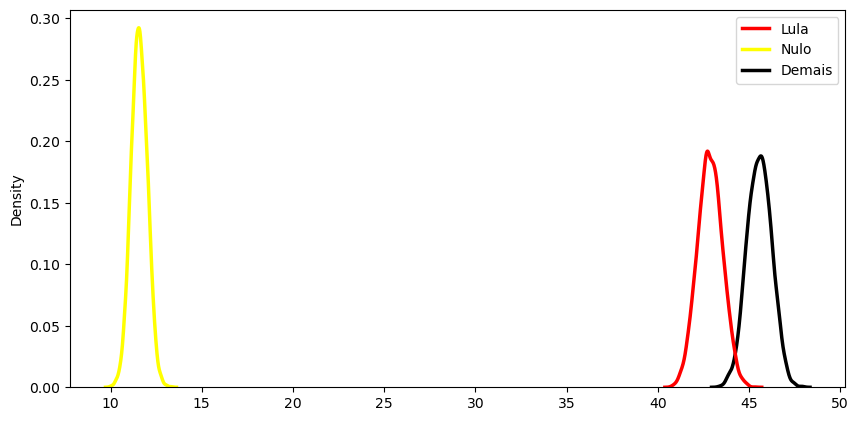

In [29]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
# ax.set_xlim(40, 50)
post_pred = pd.DataFrame({'Lula': lula, 'Nulo': nulo, 'Demais': demais})
sns.kdeplot(data=post_pred, ax=ax, palette=['red','yellow','black'], linewidth=2.5, gridsize=500);

In [30]:
(post_pred.Lula > post_pred.Demais).mean()

0.015

## DEZEMBRO

In [31]:
# NOVEMBER
prior = pd.array([6049, 1508, 7382]).astype("float32")
# DECEMBER
observed = pd.array([7376, 1953, 7578])
                    
with pm.Model() as dirichlet_model:
        
    beta = pm.Beta("beta", alpha=4, beta=1)
    
    november_prior = pm.Dirichlet(
        "november_prior",
        # Lula, BrancosNulosNaoSabem, Demais candidatos
        a=prior * beta,
    )
    
    december_like = pm.Multinomial(
        "december_like", n=observed.sum(), p=november_prior, observed=observed,
    )
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [november_prior, beta]
Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 8 seconds.


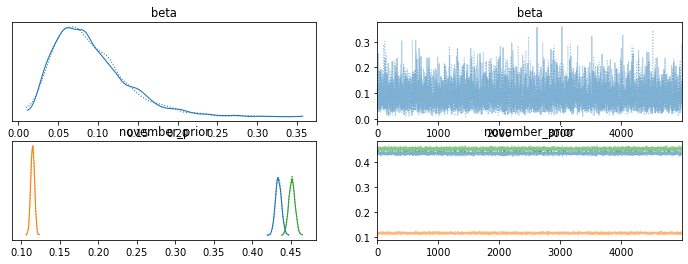

In [32]:
with dirichlet_model:
   dirichlet_trace = pm.sample(5000, chains=2, return_inferencedata=False, cores=2, progressbar=False) # 20K samples
   ppc = pm.sample_posterior_predictive(
        dirichlet_trace, random_seed=1777,
   )
   az.plot_trace(dirichlet_trace)

In [33]:
az.summary(dirichlet_trace)

Got error No model on context stack. trying to find log_likelihood in translation.
/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.091,0.045,0.018,0.174,0.001,0.0,6405.0,5935.0,1.0
november_prior[0],0.434,0.004,0.427,0.441,0.000,0.0,6678.0,7442.0,1.0
november_prior[1],0.115,0.002,0.110,0.119,0.000,0.0,4539.0,5682.0,1.0
november_prior[2],0.452,0.004,0.444,0.459,0.000,0.0,9239.0,8085.0,1.0


In [34]:
print(ppc)
ppc['december_like'].mean(axis=0)

{'december_like': array([[7476., 1993., 7438.],
       [7323., 1937., 7647.],
       [7343., 1848., 7716.],
       ...,
       [7377., 1976., 7554.],
       [7214., 1970., 7723.],
       [7430., 2124., 7353.]])}


array([7337.0841, 1936.9147, 7633.0012])

In [35]:
lula = ppc['december_like'][:, 0]
demais = ppc['december_like'][:, 2]
lula.shape,demais.shape

((10000,), (10000,))

In [36]:
(lula > demais).mean()

0.0454

# Verifica conjugado

In [37]:
# NOVEMBER
prior_data = pd.array([43, 11, 45]).astype("float32")
# DECEMBER
observed = pd.array([46, 12, 41])
                    
with pm.Model() as m:
        
    prior = pm.Dirichlet("prior", a=prior_data)
    
    pm.Multinomial("like", n=observed.sum(), p=prior, observed=observed)
    trace = pm.sample(5000, chains=2, return_inferencedata=True, cores=2, progressbar=False) # 20K samples

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior]
Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 6 seconds.


In [38]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prior[0],0.449,0.036,0.383,0.517,0.001,0.0,4759.0,5959.0,1.0
prior[1],0.116,0.024,0.075,0.162,0.000,0.0,3685.0,4786.0,1.0
prior[2],0.435,0.036,0.371,0.503,0.000,0.0,7832.0,6953.0,1.0


In [39]:
obs2 = prior_data + observed
with pm.Model() as m2:
        
    prior = pm.Dirichlet("prior", a=np.array([1.0, 1.0, 1.0]))
    
    pm.Multinomial("like", n=obs2.sum(), p=prior, observed=obs2)
    trace2 = pm.sample(5000, tune=2000, chains=2, return_inferencedata=True, cores=2, progressbar=False) # 20K samples

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior]
Sampling 2 chains for 2_000 tune and 5_000 draw iterations (4_000 + 10_000 draws total) took 7 seconds.


In [40]:
az.summary(trace2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prior[0],0.448,0.036,0.383,0.515,0.001,0.0,4534.0,5640.0,1.0
prior[1],0.120,0.024,0.078,0.164,0.000,0.0,3371.0,4330.0,1.0
prior[2],0.433,0.035,0.369,0.499,0.000,0.0,7513.0,7541.0,1.0


# Janeiro/Dezembro

4500


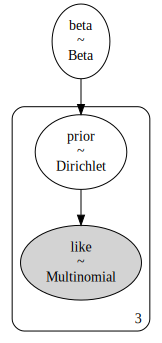

In [41]:
import numpy as np

T1 = 2_000 # 
T2 = 1_500 # EXAME/IDEIA
T3 = 1_000 # XP/IPESPE
# Mês atual: Lula, BrancosNulosNaoSabem, Demais candidatos
current_observed = np.array([1955, 535, 2010])

print(current_observed.sum())

december_data = np.array([7356, 1973, 7578]).astype("float32")

with pm.Model() as dirichlet_model:
    
    beta = pm.Beta("beta", alpha=6, beta=1)
    
    december_prior = pm.Dirichlet(
        "prior",
        # Mes anterior: Lula, BrancosNulosNaoSabem, Demais candidatos
        a = december_data * beta,
        # a = [1.0,1.0,1.0],
        shape=(3,),
    )
    
    january_like = pm.Multinomial(
        "like", n=current_observed.sum(), p=december_prior, observed=current_observed, shape=(3,)
    )
pm.model_to_graphviz(dirichlet_model)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [prior, beta]
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 16 seconds.


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/arviz/data/base.py:216: UserWarning: More chains (20000) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


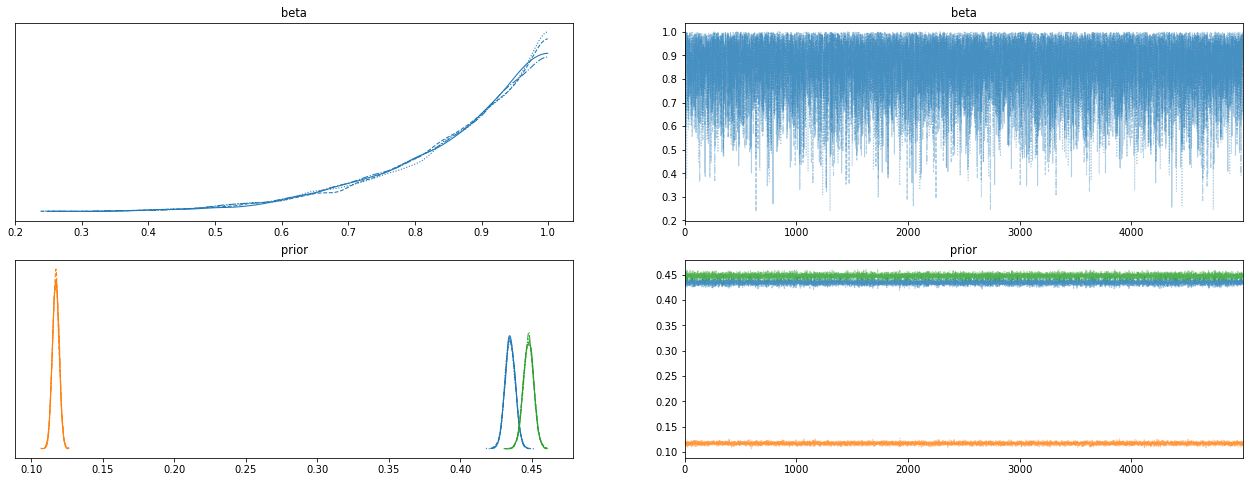

In [42]:
with dirichlet_model:
   dirichlet_trace = pm.sample(5000, chains=4, return_inferencedata=True, cores=4, progressbar=False) # 20K samples
   ppc = pm.sample_posterior_predictive(
        dirichlet_trace, random_seed=1777
   )
   az.plot_trace(dirichlet_trace, figsize=(22,8))
   dirichlet_trace.extend(az.from_dict(posterior_predictive=ppc))

In [43]:
az.summary(dirichlet_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.862,0.121,0.637,1.000,0.001,0.001,11853.0,7906.0,1.0
prior[0],0.435,0.004,0.428,0.442,0.000,0.000,11578.0,12902.0,1.0
prior[1],0.117,0.002,0.113,0.122,0.000,0.000,8673.0,10996.0,1.0
prior[2],0.448,0.004,0.441,0.455,0.000,0.000,22567.0,14657.0,1.0


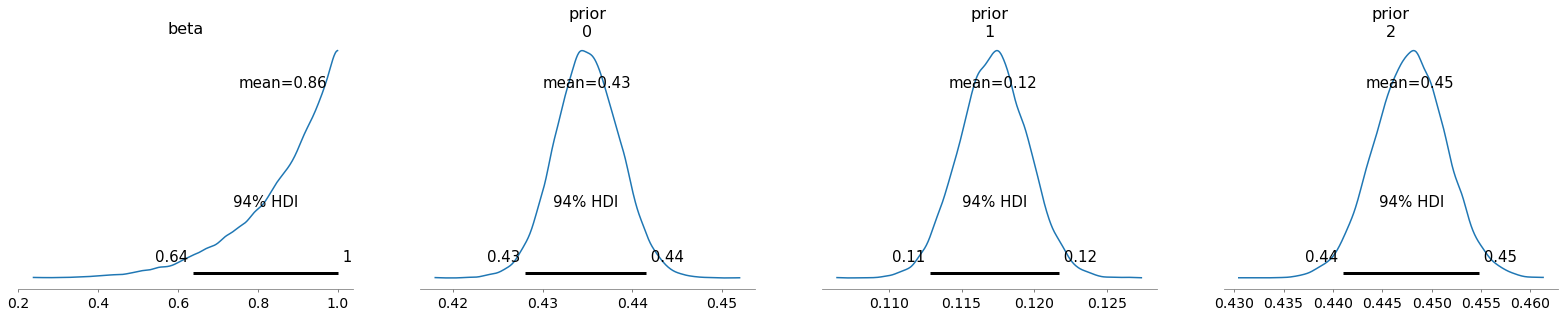

In [44]:
az.plot_posterior(dirichlet_trace);

<AxesSubplot:>

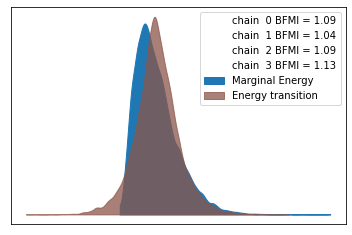

In [45]:
az.plot_energy(dirichlet_trace)

In [46]:
lula = ppc['like'][:, 0]
demais = ppc['like'][:, 2]
print(lula.shape,demais.shape)
prob_lula = (lula > demais).mean() * 100.0
print(f"Probabilidade de Lula vencer no primeiro turno é de: {prob_lula:.2f}%", )

(20000,) (20000,)
Probabilidade de Lula vencer no primeiro turno é de: 20.79%


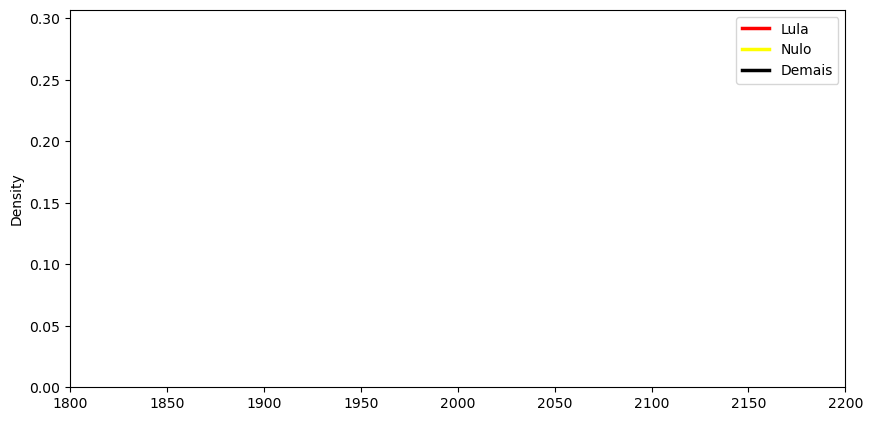

In [47]:
# create figure and axes
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
ax.set_xlim(1800, 2200)
sns.kdeplot(data=post_pred, ax=ax, palette=['red','yellow','black'], linewidth=2.5, gridsize=500);

## Playground

In [48]:
import math
1 - stats.norm.cdf(0, loc=-1, scale=math.sqrt(5))

0.32736042300928847

In [49]:
import scipy as sp
true_p = sp.stats.dirichlet(6.0 * np.array([0.45, 0.3, 0.15, 0.9, 0.01])).rvs(size=10)
observed = np.vstack([sp.stats.multinomial(n=50, p=p_i).rvs() for p_i in true_p])



In [50]:
observed.sum(axis=1)

array([50, 50, 50, 50, 50, 50, 50, 50, 50, 50])

In [51]:
current_observed.sum(axis=0)

4500

In [52]:
current_observed.sum(axis=1)

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
current_observed

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact
from datetime import datetime
import plotly.io as pio
# Default is plotly_mimetype+notebook, but jekyll fails to parse plotly_mimetype.
pio.renderers.default = 'notebook_connected'

# Inject the missing require.js dependency.
from IPython.display import display, HTML
js = '<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.6/require.min.js" integrity="sha512-c3Nl8+7g4LMSTdrm621y7kf9v3SDPnhxLNhcjFJbKECVnmZHTdo+IRO05sNLTH/D3vA6u1X32ehoLC7WFVdheg==" crossorigin="anonymous"></script>'
display(HTML(js))
import plotly.express as px

df = px.data.gapminder()
px.scatter(df, x="gdpPercap", y="lifeExp", animation_frame="year", animation_group="country",
           size="pop", color="continent", hover_name="country",
           log_x=True, size_max=55, range_x=[100,100000], range_y=[25,90])


In [ ]:
# hide_input
# This cell is required for the export to HTML to work.


In [ ]:
observed_prior = np.array([7356., 1973., 7578.])
prior = []
N = 4000
for it in range(N):
    b = stats.beta.rvs(a=5, b=1, size=3)
    # print(b)
    # print(observed_prior * b)
    diric = stats.dirichlet.rvs(observed_prior * b,)
    # print(diric[0])
    prior.append(diric[0])
prior = np.array(prior)
print(prior[:4])

In [ ]:

print((prior[:,0] > prior[:,2]).mean())
print(prior.shape)


In [ ]:
posterior = []
for it in range(N):
    mn = stats.multinomial.rvs(n=3000, p=[1340/3000, 370/3000, 1290/3000])
    posterior.append(mn * prior[it])
posterior = np.array(posterior)



In [ ]:
post = posterior#/posterior.sum(axis=1).reshape(4000,1)
print(post.sum(axis=1))
print(post[:10, 0])
print(post[:10, 2])

In [ ]:
lula = post[:, 0]
others = post[:, 2]
print((lula > others).mean())

In [ ]:
simul = []
for it in range(N):
    idx = np.random.choice(N,1)[0]
    #print(idx)
    #print(post[idx])
    dir2 = stats.dirichlet.rvs(post[idx])[0]
    simul.append(dir2)
dir2 = np.array(simul)

In [ ]:
dir2

In [ ]:
lula = dir2[:, 0]
others = dir2[:, 2]
print((lula > others).mean())

In [ ]:
np.arange(10)

In [ ]:
np.linspace(0,1, 101)

In [ ]:
x = np.arange(5,10)

In [ ]:
np.concatenate([[x[0] - 5], x, [x[-1] + 5]])

In [58]:
1.96 * np.sqrt((0.5**2)/3000)

0.017892270211835426

In [73]:
1./(1./0.01789 + 1./0.0200)

0.009443124835048826

In [64]:
1/100

0.01

In [71]:
1/(1./0.01789 + 1./0.0200)

0.009443124835048826